In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from Bayesian2 import BayesianLinearRegression
from Bayesian2 import SklearnBayesianLinearRegression

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-01-01,a624fb9a,SE-064c0cec-1189,3095,02 SLB,7.0,191.0,2022-1,30.77,0.000000,...,35.914865,0.856748,0.000000,0,0,0,0,-3.025000,28.012944,0.009435
1,2022-01-02,a624fb9a,SE-064c0cec-1189,3096,02 SLB,7.0,192.0,2022-1,48.22,30.770000,...,35.799613,1.103224,0.243718,0,0,0,0,-0.279167,32.898193,0.009435
2,2022-01-03,a624fb9a,SE-064c0cec-1189,3097,02 SLB,7.0,193.0,2022-1,30.53,39.495000,...,35.684360,1.023044,-0.083744,0,0,0,0,2.033333,36.760487,0.009435
3,2022-01-04,a624fb9a,SE-064c0cec-1189,3098,02 SLB,7.0,194.0,2022-1,42.26,36.506667,...,35.569108,1.066796,0.040438,0,0,0,0,0.066667,31.939524,0.009435
4,2022-01-05,a624fb9a,SE-064c0cec-1189,3099,02 SLB,7.0,195.0,2022-1,38.49,37.945000,...,35.453856,1.073339,0.003074,0,0,0,0,-3.700000,26.498206,0.009435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483097,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,41 Fjällko,10.0,347.0,2023-3,12.67,14.652000,...,13.608593,1.030966,-0.045706,0,1,0,0,12.666667,53.132530,0.001001
483098,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,41 Fjällko,10.0,348.0,2023-3,22.31,14.030000,...,13.516773,1.108549,0.070579,0,1,0,0,13.079167,56.726870,0.001001
483099,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,41 Fjällko,10.0,349.0,2023-3,12.84,14.984000,...,13.424952,1.109278,-0.006853,0,1,0,0,14.237500,58.482418,0.001001
483100,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,41 Fjällko,10.0,350.0,2023-3,9.47,14.892000,...,13.333131,1.095617,-0.021300,0,1,0,0,15.345833,60.546358,0.001001


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the features are float type
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)

# Scale features
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature pairs
temp_pair = ['MeanTemperature', 'MeanTHI_adj']
hw_pair = ['HW', 'cum_HW']

# List to store model instances for each cow
models = []

# Function to fit the Bayesian Linear Regression model for cross-validation
def fit_bayesian_model_cv(data, selected_feats):
    # Calculate global priors from the HeatStress data
    global_mean = data['NormalizedDailyYield'].mean()
    global_variance = data['NormalizedDailyYield'].var()
    if global_variance < 1e-6:
        global_variance = 1e-6
    global_beta = 1 / global_variance

    # Calculate prior means for the features based on the HeatStress data
    prior_mean_values = [data[feature].mean() for feature in selected_feats]

    # Define priors with stronger regularization
    prior_mean = np.array([global_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.1

    model = SklearnBayesianLinearRegression(
        dataframe=data,
        subject_name='farm',
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=global_beta
    )

    return model

# Function to perform cross-validation and find the best feature combination
def find_best_feature_combination(data, temp_pair, hw_pair):
    best_features = None
    lowest_mse = float('inf')

    # Iterate over all combinations of temp and hw pairs
    for temp_feature in temp_pair:
        for hw_feature in hw_pair:
            features = [temp_feature, hw_feature]
            valid_features = [feat for feat in features if data[feat].std() > 0]
            
            if not valid_features:
                print(f"No valid features left for cross-validation with features {features}. Skipping...")
                continue

            X_val = data[valid_features].astype(np.float64).values
            y_val = data['NormalizedDailyYield'].astype(np.float64).values

            model = fit_bayesian_model_cv(data, valid_features)

            cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
            mean_cv_score = -cv_scores.mean()
            std_cv_score = cv_scores.std()

            print(f"Cross-validation MSE for features {valid_features}: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

            if mean_cv_score < lowest_mse:
                lowest_mse = mean_cv_score
                best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, temp_pair, hw_pair)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, selected_feats):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]

        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior means for the features based on the entire HeatStress data
        prior_mean_values = [data_heatstress[feature].mean() for feature in selected_feats]

        # Define priors
        prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
        prior_cov = np.eye(len(selected_feats) + 1) * 0.1  # Stronger regularization

        # Initialize and fit the model on the entire dataset with the selected features
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=selected_feats,
            target='NormalizedDailyYield',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store the model instance for later use
        models.append(model)

        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']

    return yield_changes

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})
results_df

Cross-validation MSE for features ['MeanTemperature', 'HW']: 0.0133 ± 0.0030
Cross-validation MSE for features ['MeanTemperature', 'cum_HW']: 0.0135 ± 0.0031
Cross-validation MSE for features ['MeanTHI_adj', 'HW']: 0.0133 ± 0.0031
Cross-validation MSE for features ['MeanTHI_adj', 'cum_HW']: 0.0135 ± 0.0031
Best features: ['MeanTemperature', 'HW'], with MSE: 0.01325678372027576


,SE_Number,Yield HeatStress
0,SE-064c0cec-1189,0.930954
1,SE-30dc5787-1389,0.910039
2,SE-30dc5787-1396,0.913319
3,SE-30dc5787-1402,0.993928
4,SE-a624fb9a-1039,1.003306
...,...,...
131,SE-a624fb9a-1491,0.957697
132,SE-a624fb9a-1493,0.768462
133,SE-a624fb9a-1496,0.951796
134,SE-a624fb9a-1503,0.974609


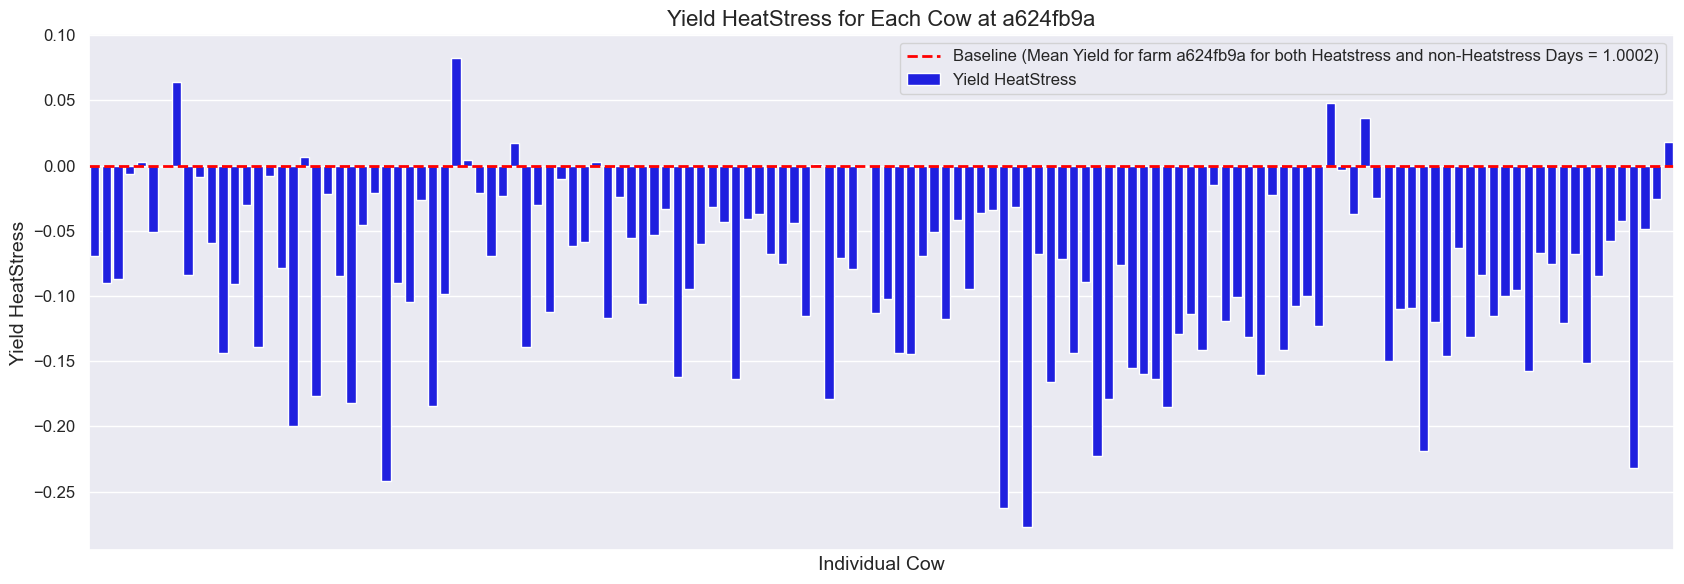

In [4]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

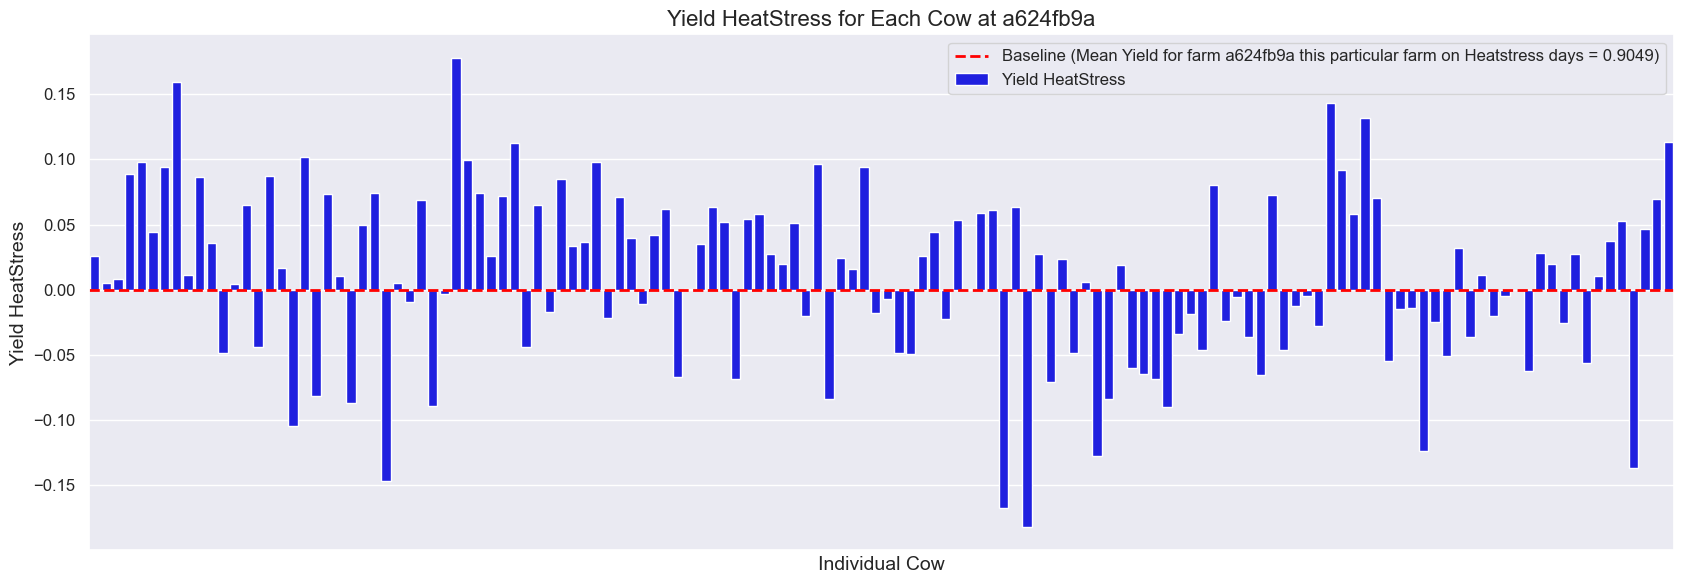

In [5]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

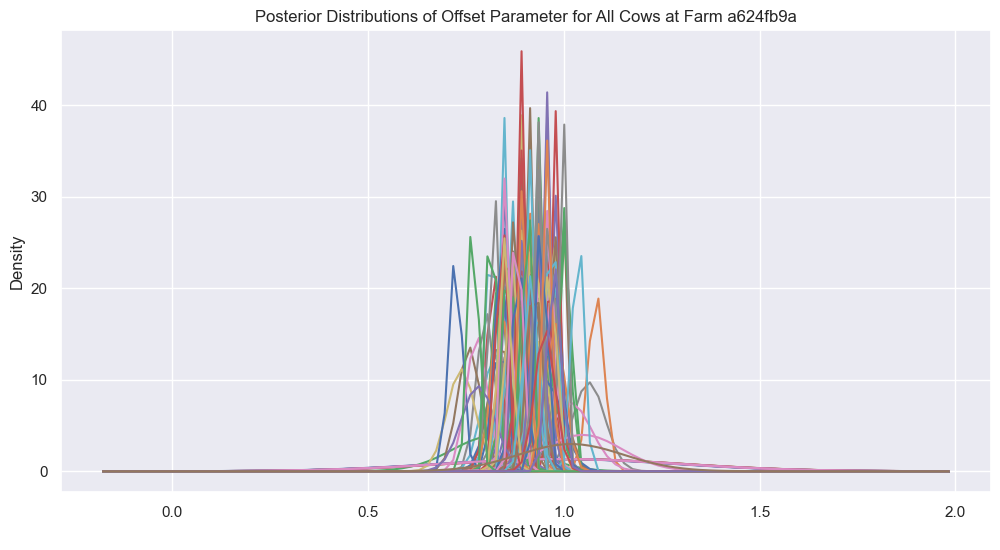

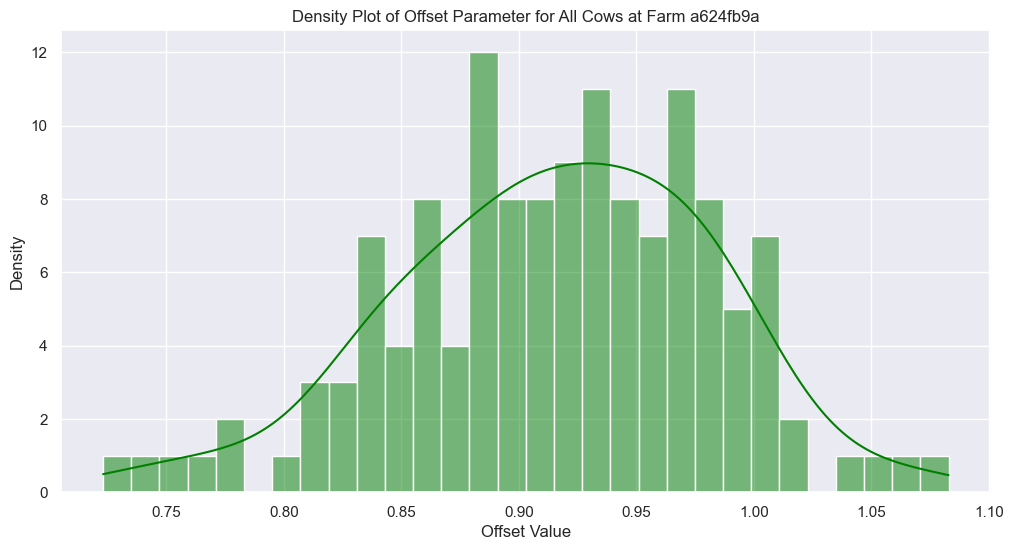

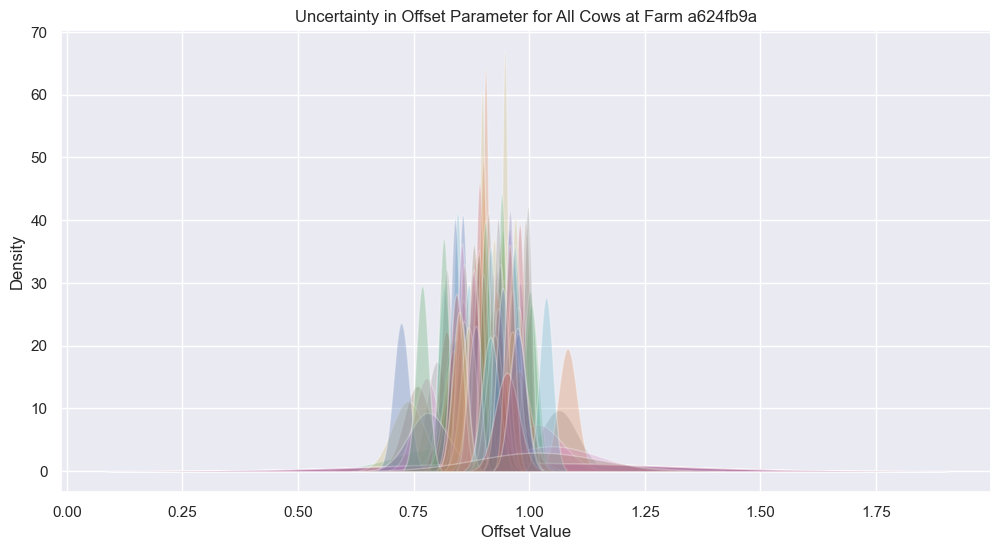

In [6]:
# Initialize lists to store aggregated data
offset_mus = []
offset_sigmas = []

# Extract offset parameters from each model
for model in models:
    offset_mu = model.posterior.mean[0][0]
    offset_sigma = np.sqrt(model.posterior.cov[0, 0])
    offset_mus.append(offset_mu)
    offset_sigmas.append(offset_sigma)

# Posterior Distribution Plot for all cows
plt.figure(figsize=(12, 6))
xx = np.linspace(min(offset_mus) - 3 * max(offset_sigmas), max(offset_mus) + 3 * max(offset_sigmas), 100)
for mu, sigma in zip(offset_mus, offset_sigmas):
    sns.lineplot(x=xx, y=stats.norm.pdf(xx, mu, sigma))
plt.title(f'Posterior Distributions of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot for all offset parameter estimates
plt.figure(figsize=(12, 6))
sns.histplot(offset_mus, bins=30, kde=True, color='green')
plt.title(f'Density Plot of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Uncertainty Plot for all cows
plt.figure(figsize=(12, 6))
for mu, sigma in zip(offset_mus, offset_sigmas):
    xx = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.fill_between(xx, stats.norm.pdf(xx, mu, sigma), alpha=0.3)
plt.title(f'Uncertainty in Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Farm 5c06d92d

In [7]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the features are float type
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)

# Scale features
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature pairs
temp_pair = ['MeanTemperature', 'MeanTHI_adj']
hw_pair = ['HW', 'cum_HW']

# List to store model instances for each cow
models = []

# Function to fit the Bayesian Linear Regression model for cross-validation
def fit_bayesian_model_cv(data, selected_feats):
    # Calculate global priors from the HeatStress data
    global_mean = data['NormalizedDailyYield'].mean()
    global_variance = data['NormalizedDailyYield'].var()
    if global_variance < 1e-6:
        global_variance = 1e-6
    global_beta = 1 / global_variance

    # Calculate prior means for the features based on the HeatStress data
    prior_mean_values = [data[feature].mean() for feature in selected_feats]

    # Define priors with stronger regularization
    prior_mean = np.array([global_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.1

    model = SklearnBayesianLinearRegression(
        dataframe=data,
        subject_name='farm',
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=global_beta
    )

    return model

# Function to perform cross-validation and find the best feature combination
def find_best_feature_combination(data, temp_pair, hw_pair):
    best_features = None
    lowest_mse = float('inf')

    # Iterate over all combinations of temp and hw pairs
    for temp_feature in temp_pair:
        for hw_feature in hw_pair:
            features = [temp_feature, hw_feature]
            valid_features = [feat for feat in features if data[feat].std() > 0]
            
            if not valid_features:
                print(f"No valid features left for cross-validation with features {features}. Skipping...")
                continue

            X_val = data[valid_features].astype(np.float64).values
            y_val = data['NormalizedDailyYield'].astype(np.float64).values

            model = fit_bayesian_model_cv(data, valid_features)

            cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
            mean_cv_score = -cv_scores.mean()
            std_cv_score = cv_scores.std()

            print(f"Cross-validation MSE for features {valid_features}: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

            if mean_cv_score < lowest_mse:
                lowest_mse = mean_cv_score
                best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, temp_pair, hw_pair)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, selected_feats):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]

        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior means for the features based on the entire HeatStress data
        prior_mean_values = [data_heatstress[feature].mean() for feature in selected_feats]

        # Define priors
        prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
        prior_cov = np.eye(len(selected_feats) + 1) * 0.1  # Stronger regularization

        # Initialize and fit the model on the entire dataset with the selected features
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=selected_feats,
            target='NormalizedDailyYield',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store the model instance for later use
        models.append(model)

        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']

    return yield_changes

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})
results_df

Cross-validation MSE for features ['MeanTemperature', 'HW']: 0.0110 ± 0.0033
Cross-validation MSE for features ['MeanTemperature', 'cum_HW']: 0.0110 ± 0.0034
Cross-validation MSE for features ['MeanTHI_adj', 'HW']: 0.0110 ± 0.0033
Cross-validation MSE for features ['MeanTHI_adj', 'cum_HW']: 0.0109 ± 0.0034
Best features: ['MeanTHI_adj', 'cum_HW'], with MSE: 0.010949248022325709


,SE_Number,Yield HeatStress
0,SE-5c06d92d-2000,1.000218
1,SE-5c06d92d-2016,0.887571
2,SE-5c06d92d-2055,0.917540
3,SE-5c06d92d-2058,0.909330
4,SE-5c06d92d-2211,0.964650
...,...,...
437,SE-5c06d92d-3474,1.001567
438,SE-5c06d92d-3475,0.863037
439,SE-5c06d92d-3478,0.995740
440,SE-5c06d92d-3482,1.071954


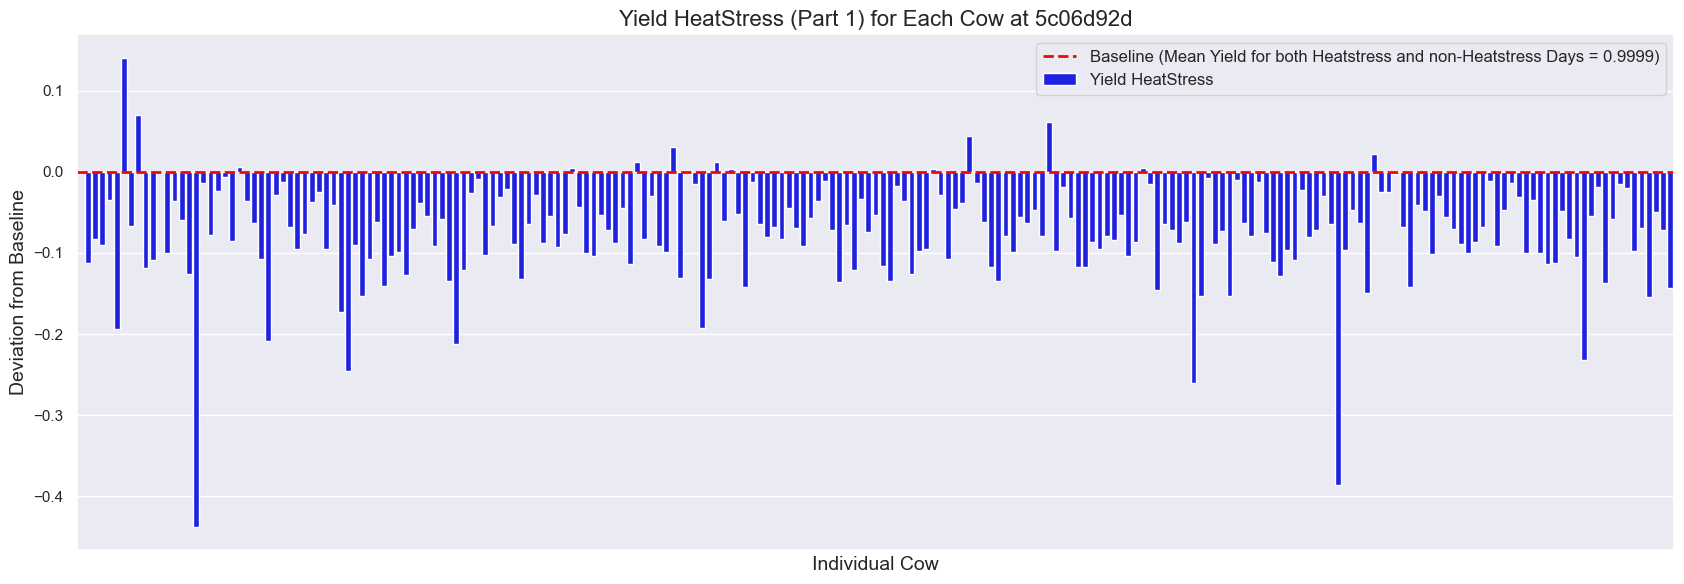

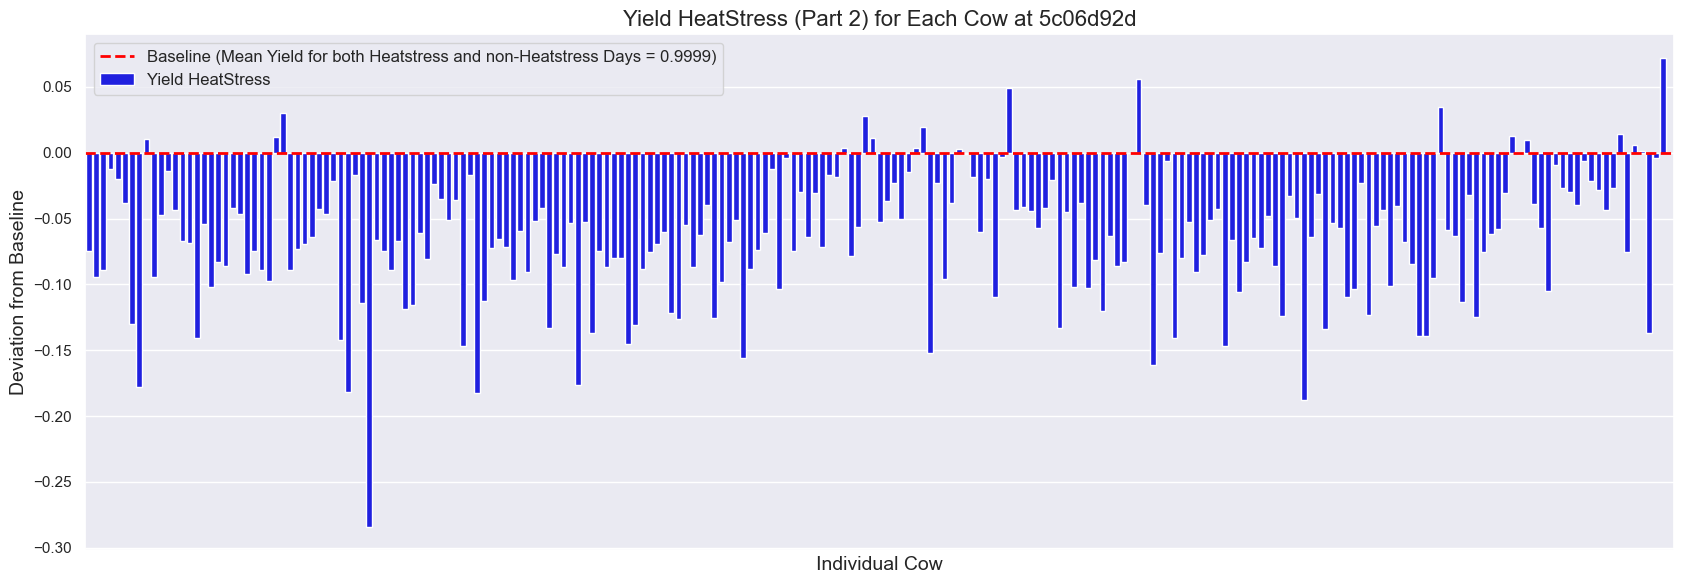

In [8]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

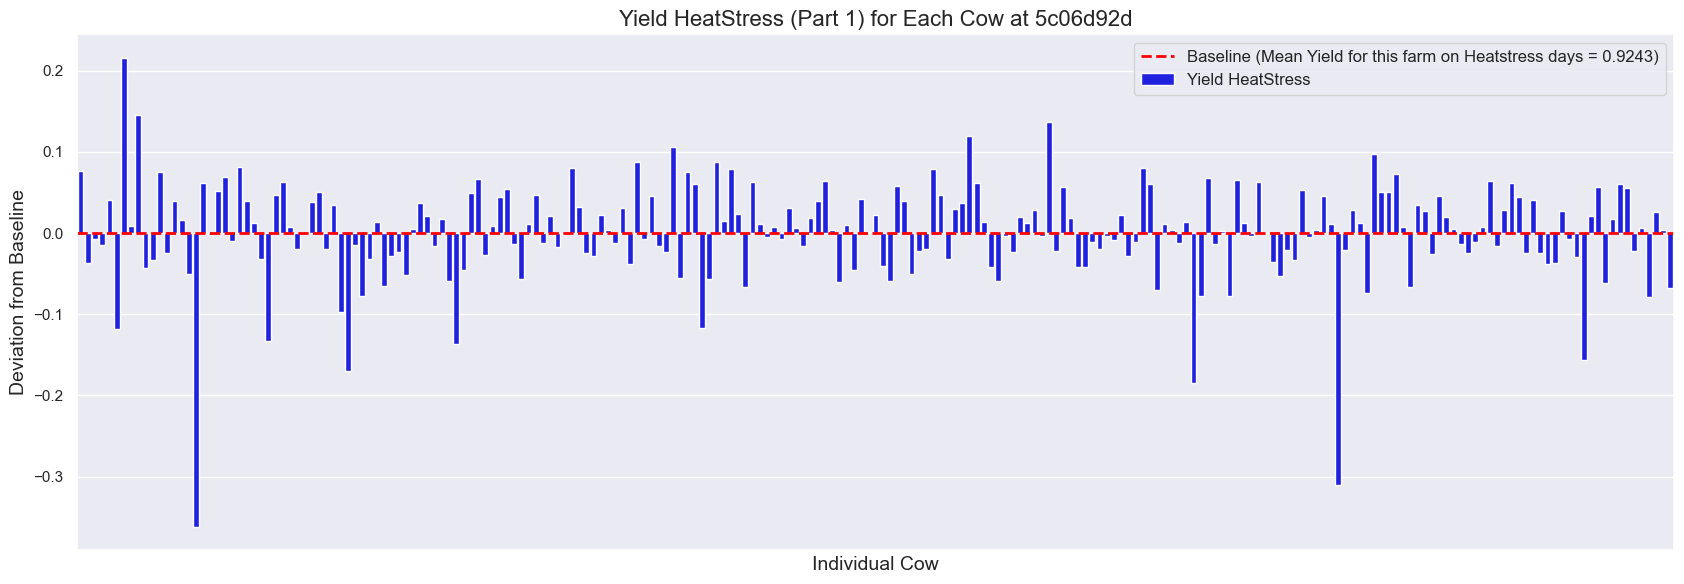

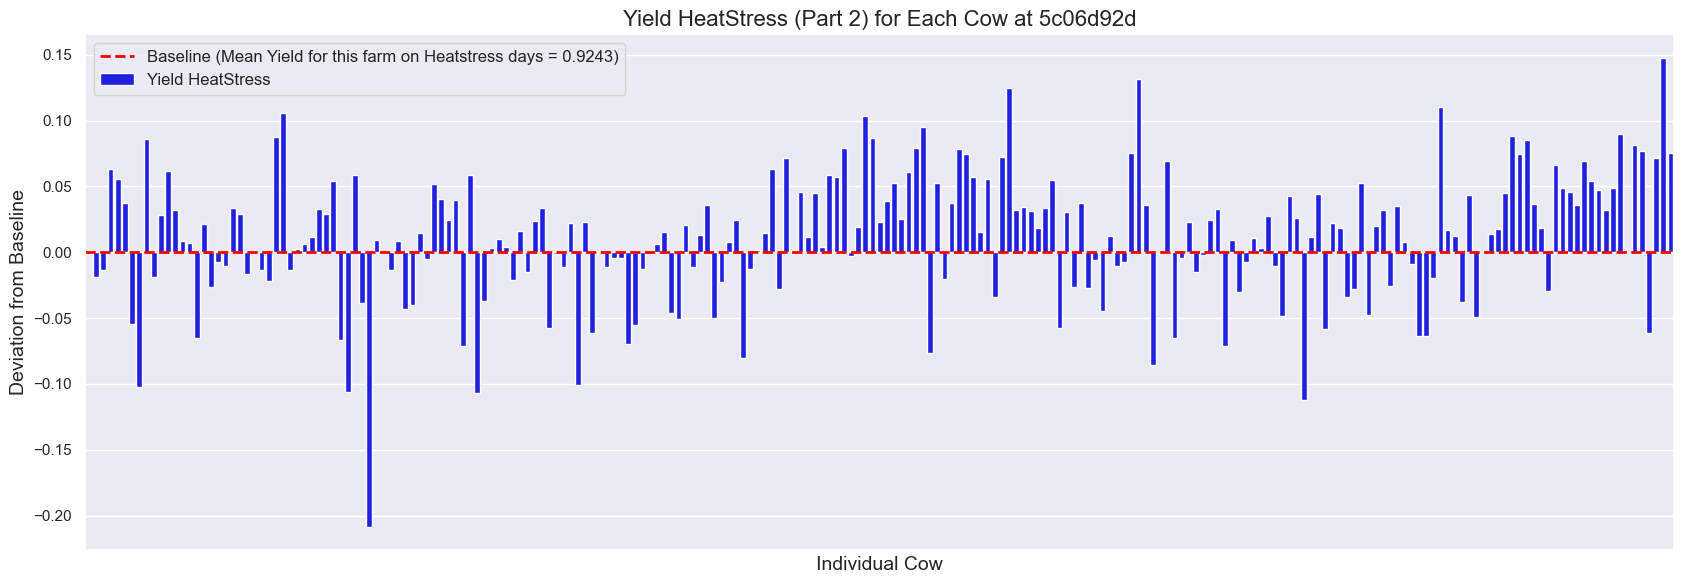

In [9]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

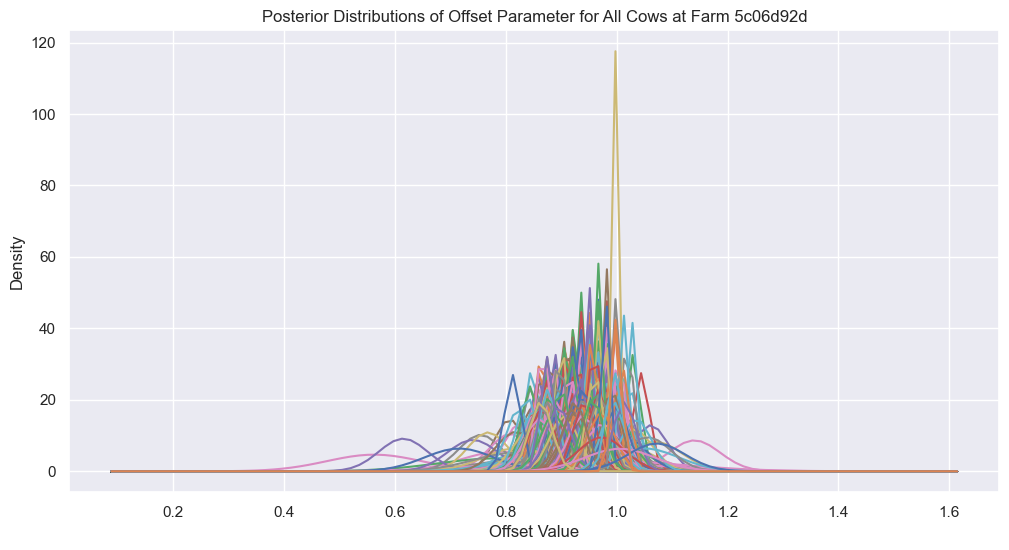

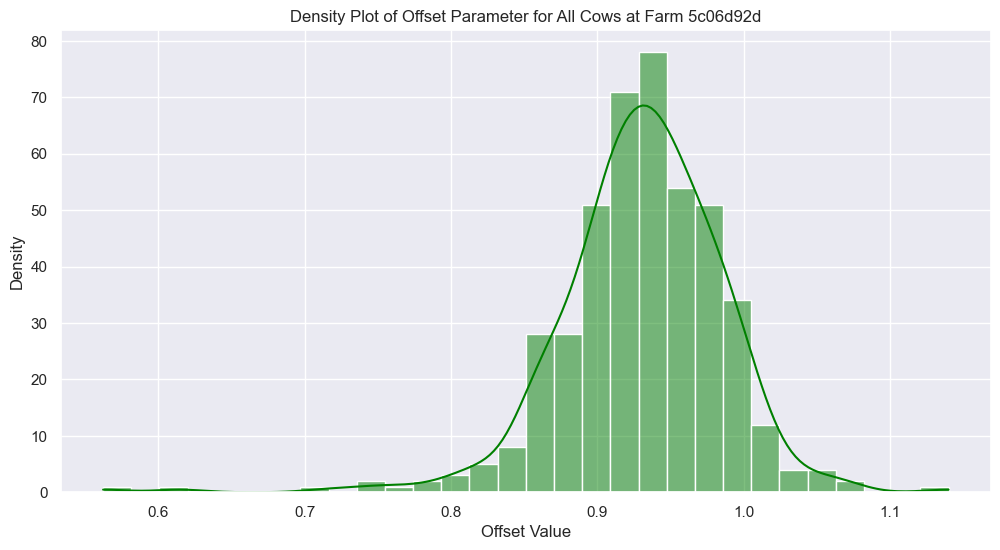

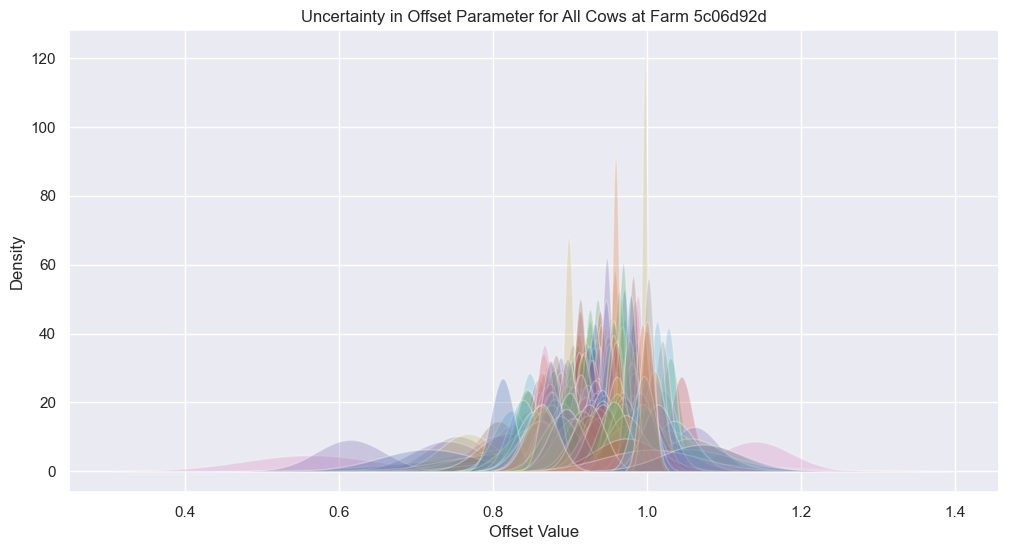

In [10]:
# Initialize lists to store aggregated data
offset_mus = []
offset_sigmas = []

# Extract offset parameters from each model
for model in models:
    offset_mu = model.posterior.mean[0][0]
    offset_sigma = np.sqrt(model.posterior.cov[0, 0])
    offset_mus.append(offset_mu)
    offset_sigmas.append(offset_sigma)

# Posterior Distribution Plot for all cows
plt.figure(figsize=(12, 6))
xx = np.linspace(min(offset_mus) - 3 * max(offset_sigmas), max(offset_mus) + 3 * max(offset_sigmas), 100)
for mu, sigma in zip(offset_mus, offset_sigmas):
    sns.lineplot(x=xx, y=stats.norm.pdf(xx, mu, sigma))
plt.title(f'Posterior Distributions of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot for all offset parameter estimates
plt.figure(figsize=(12, 6))
sns.histplot(offset_mus, bins=30, kde=True, color='green')
plt.title(f'Density Plot of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Uncertainty Plot for all cows
plt.figure(figsize=(12, 6))
for mu, sigma in zip(offset_mus, offset_sigmas):
    xx = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.fill_between(xx, stats.norm.pdf(xx, mu, sigma), alpha=0.3)
plt.title(f'Uncertainty in Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Farm 752efd72

In [11]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the features are float type
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)

# Scale features
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature pairs
temp_pair = ['MeanTemperature', 'MeanTHI_adj']
hw_pair = ['HW', 'cum_HW']

# List to store model instances for each cow
models = []

# Function to fit the Bayesian Linear Regression model for cross-validation
def fit_bayesian_model_cv(data, selected_feats):
    # Calculate global priors from the HeatStress data
    global_mean = data['NormalizedDailyYield'].mean()
    global_variance = data['NormalizedDailyYield'].var()
    if global_variance < 1e-6:
        global_variance = 1e-6
    global_beta = 1 / global_variance

    # Calculate prior means for the features based on the HeatStress data
    prior_mean_values = [data[feature].mean() for feature in selected_feats]

    # Define priors with stronger regularization
    prior_mean = np.array([global_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.1

    model = SklearnBayesianLinearRegression(
        dataframe=data,
        subject_name='farm',
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=global_beta
    )

    return model

# Function to perform cross-validation and find the best feature combination
def find_best_feature_combination(data, temp_pair, hw_pair):
    best_features = None
    lowest_mse = float('inf')

    # Iterate over all combinations of temp and hw pairs
    for temp_feature in temp_pair:
        for hw_feature in hw_pair:
            features = [temp_feature, hw_feature]
            valid_features = [feat for feat in features if data[feat].std() > 0]
            
            if not valid_features:
                print(f"No valid features left for cross-validation with features {features}. Skipping...")
                continue

            X_val = data[valid_features].astype(np.float64).values
            y_val = data['NormalizedDailyYield'].astype(np.float64).values

            model = fit_bayesian_model_cv(data, valid_features)

            cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
            mean_cv_score = -cv_scores.mean()
            std_cv_score = cv_scores.std()

            print(f"Cross-validation MSE for features {valid_features}: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

            if mean_cv_score < lowest_mse:
                lowest_mse = mean_cv_score
                best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, temp_pair, hw_pair)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, selected_feats):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]

        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior means for the features based on the entire HeatStress data
        prior_mean_values = [data_heatstress[feature].mean() for feature in selected_feats]

        # Define priors
        prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
        prior_cov = np.eye(len(selected_feats) + 1) * 0.1  # Stronger regularization

        # Initialize and fit the model on the entire dataset with the selected features
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=selected_feats,
            target='NormalizedDailyYield',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store the model instance for later use
        models.append(model)

        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']

    return yield_changes

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})
results_df

Cross-validation MSE for features ['MeanTemperature', 'HW']: 0.0073 ± 0.0014
Cross-validation MSE for features ['MeanTemperature', 'cum_HW']: 0.0077 ± 0.0015
Cross-validation MSE for features ['MeanTHI_adj', 'HW']: 0.0073 ± 0.0014
Cross-validation MSE for features ['MeanTHI_adj', 'cum_HW']: 0.0077 ± 0.0015
Best features: ['MeanTemperature', 'HW'], with MSE: 0.007266412948766983


,SE_Number,Yield HeatStress
0,SE-752efd72-0001,0.911034
1,SE-752efd72-0002,1.121123
2,SE-752efd72-0008,1.011982
3,SE-752efd72-0010,0.960412
4,SE-752efd72-0011,0.982189
...,...,...
362,SE-752efd72-2793,1.031051
363,SE-752efd72-2794,0.879314
364,SE-752efd72-2795,0.957356
365,SE-752efd72-2796,1.023077


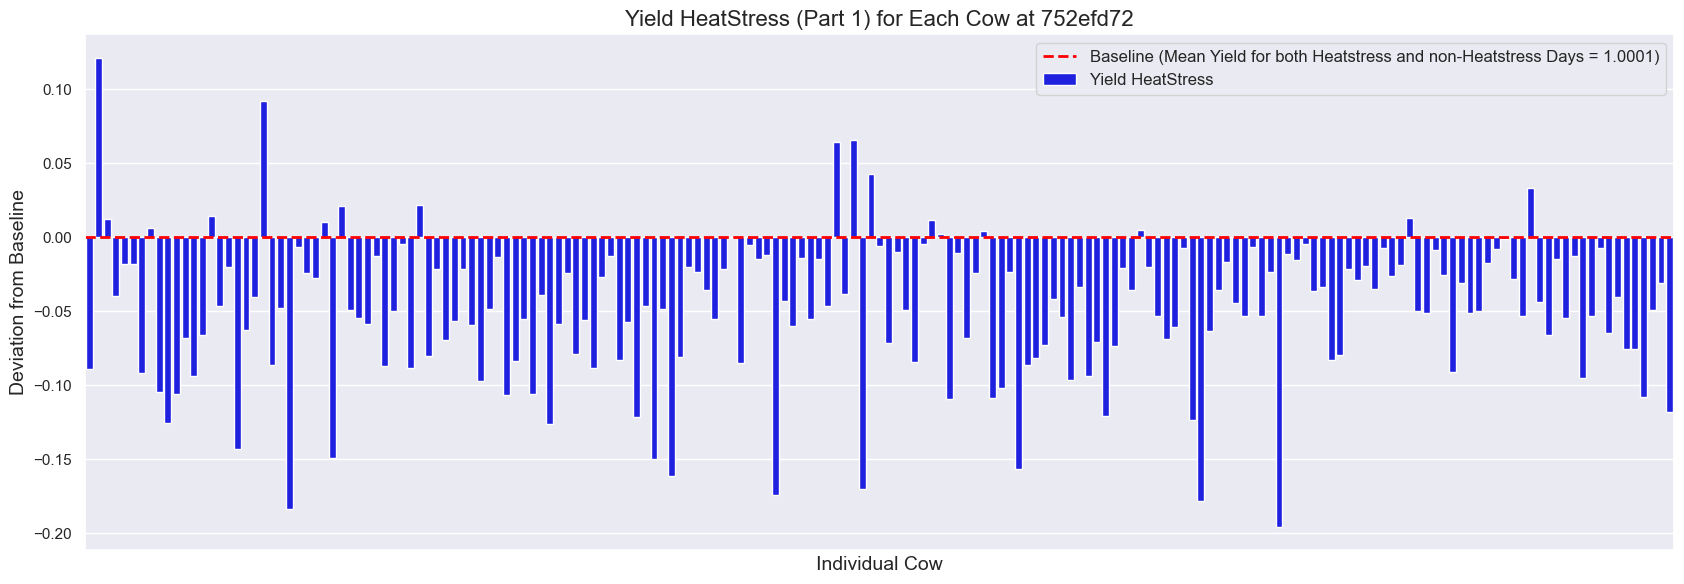

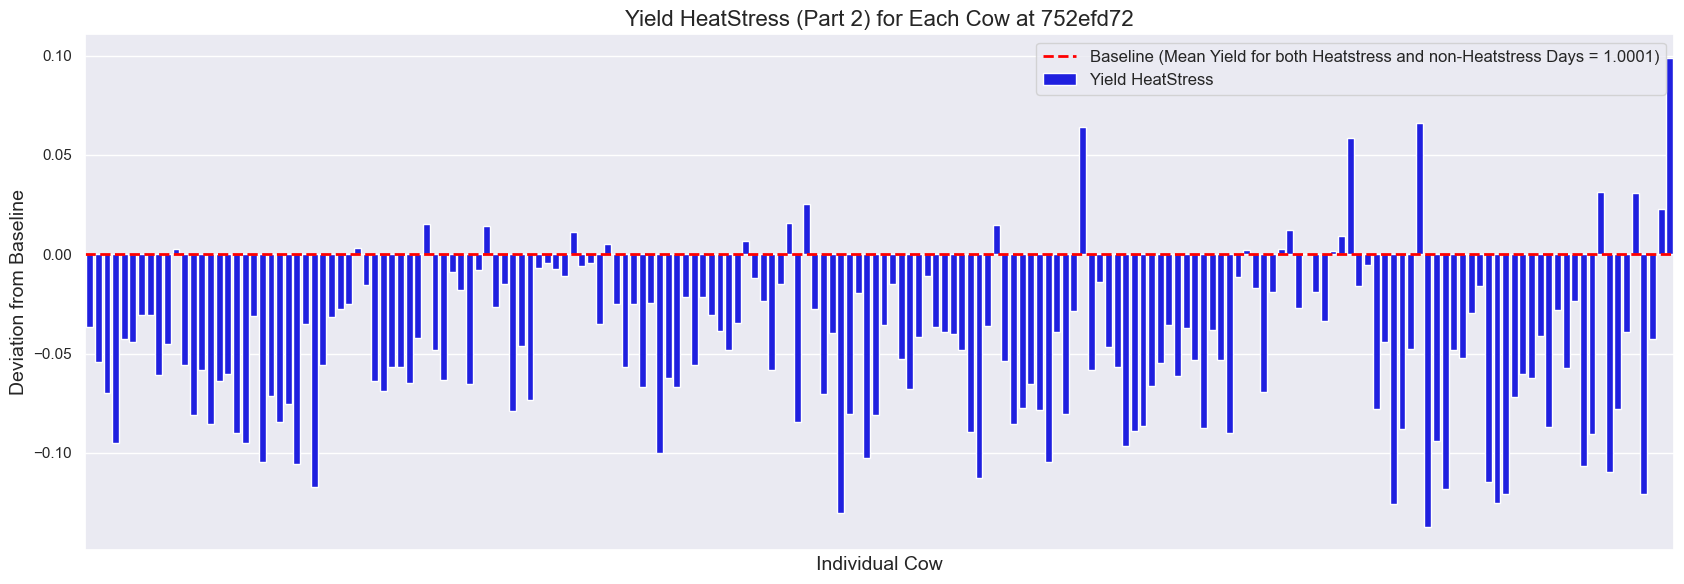

In [12]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

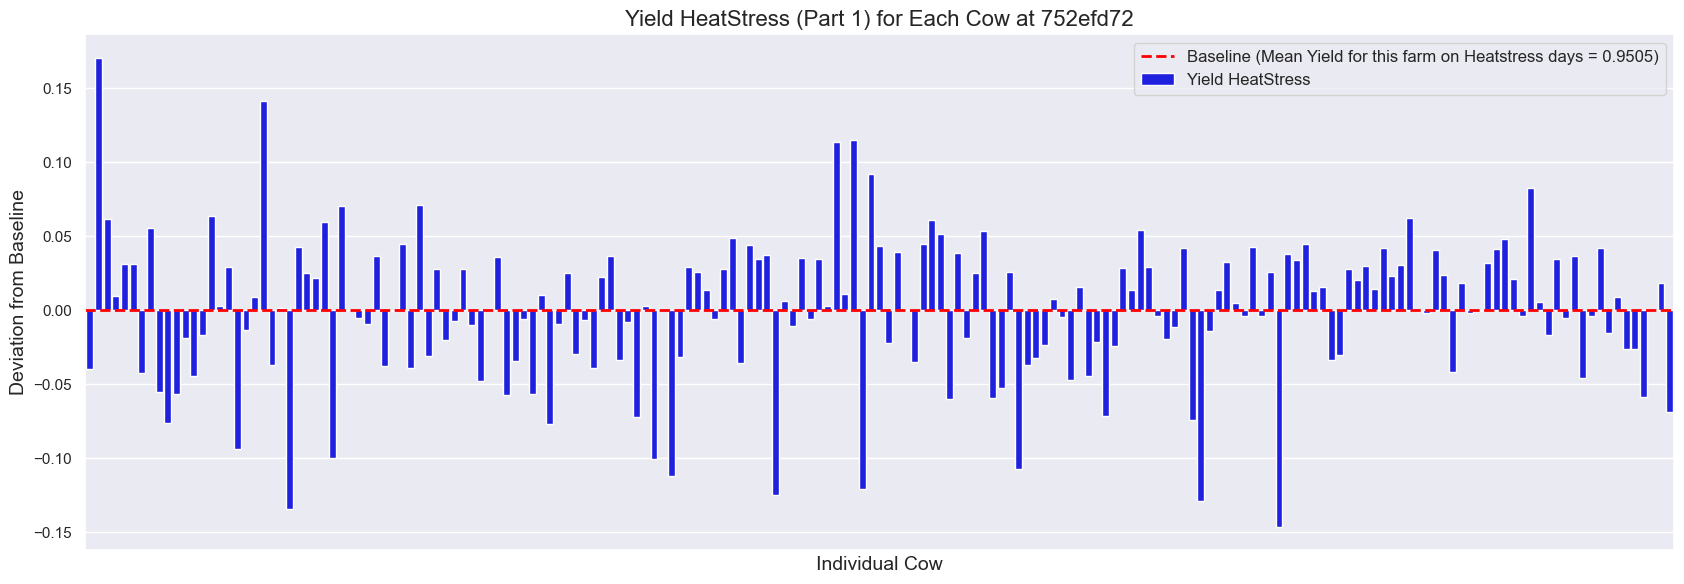

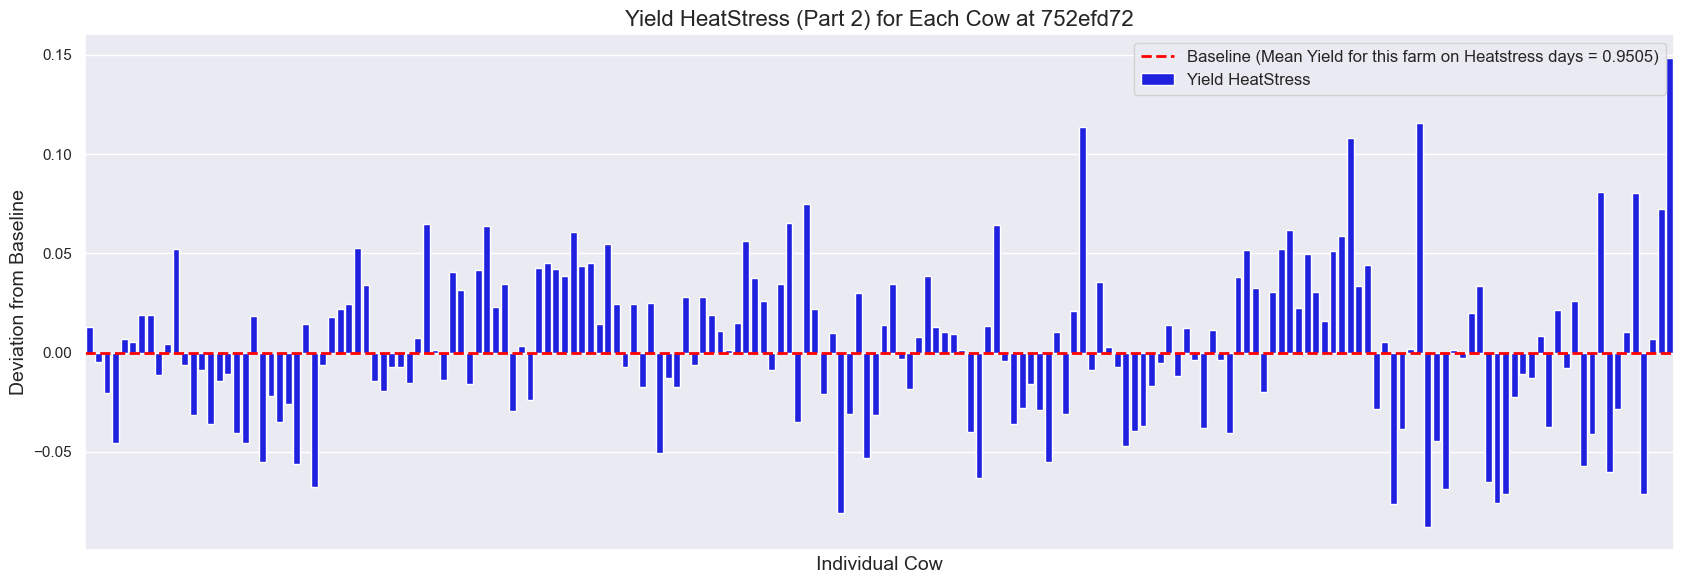

In [13]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

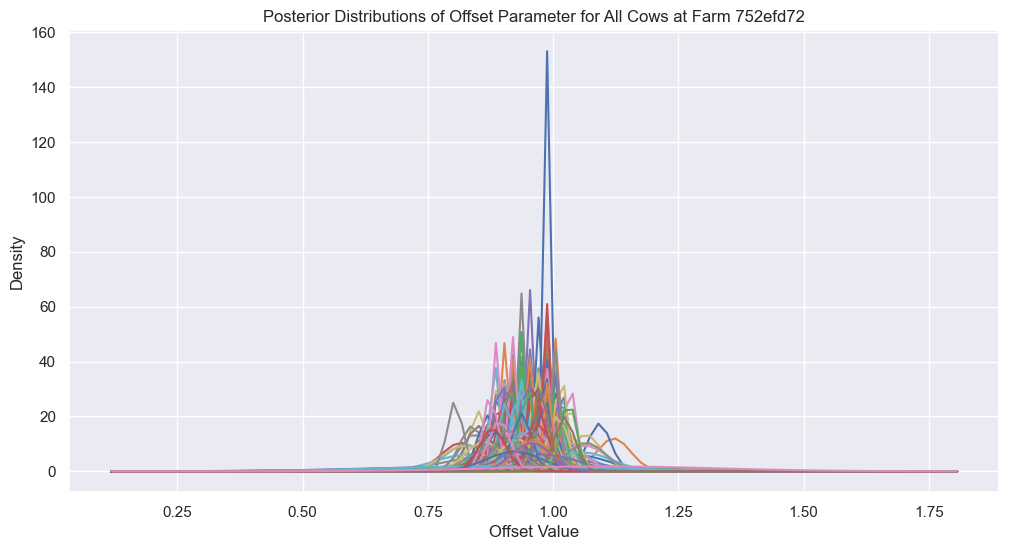

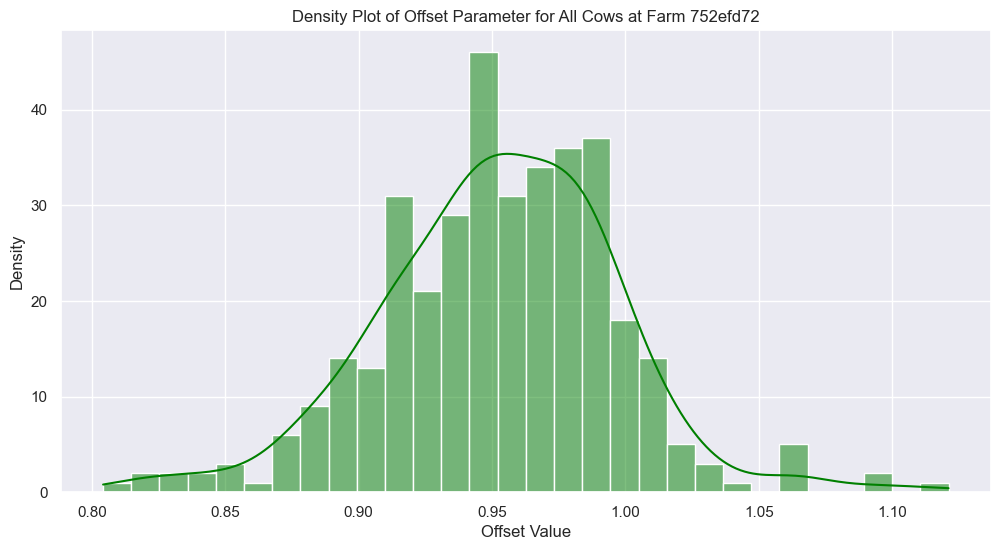

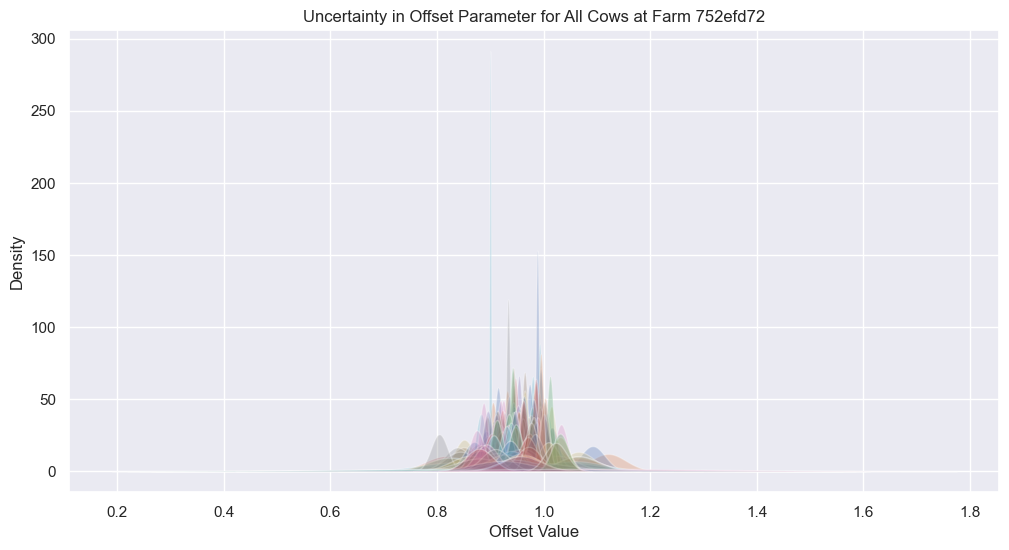

In [14]:
# Initialize lists to store aggregated data
offset_mus = []
offset_sigmas = []

# Extract offset parameters from each model
for model in models:
    offset_mu = model.posterior.mean[0][0]
    offset_sigma = np.sqrt(model.posterior.cov[0, 0])
    offset_mus.append(offset_mu)
    offset_sigmas.append(offset_sigma)

# Posterior Distribution Plot for all cows
plt.figure(figsize=(12, 6))
xx = np.linspace(min(offset_mus) - 3 * max(offset_sigmas), max(offset_mus) + 3 * max(offset_sigmas), 100)
for mu, sigma in zip(offset_mus, offset_sigmas):
    sns.lineplot(x=xx, y=stats.norm.pdf(xx, mu, sigma))
plt.title(f'Posterior Distributions of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot for all offset parameter estimates
plt.figure(figsize=(12, 6))
sns.histplot(offset_mus, bins=30, kde=True, color='green')
plt.title(f'Density Plot of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Uncertainty Plot for all cows
plt.figure(figsize=(12, 6))
for mu, sigma in zip(offset_mus, offset_sigmas):
    xx = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.fill_between(xx, stats.norm.pdf(xx, mu, sigma), alpha=0.3)
plt.title(f'Uncertainty in Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Farm f454e660

In [15]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the features are float type
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)

# Scale features
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature pairs
temp_pair = ['MeanTemperature', 'MeanTHI_adj']
hw_pair = ['HW', 'cum_HW']

# List to store model instances for each cow
models = []

# Function to fit the Bayesian Linear Regression model for cross-validation
def fit_bayesian_model_cv(data, selected_feats):
    # Calculate global priors from the HeatStress data
    global_mean = data['NormalizedDailyYield'].mean()
    global_variance = data['NormalizedDailyYield'].var()
    if global_variance < 1e-6:
        global_variance = 1e-6
    global_beta = 1 / global_variance

    # Calculate prior means for the features based on the HeatStress data
    prior_mean_values = [data[feature].mean() for feature in selected_feats]

    # Define priors with stronger regularization
    prior_mean = np.array([global_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.1

    model = SklearnBayesianLinearRegression(
        dataframe=data,
        subject_name='farm',
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=global_beta
    )

    return model

# Function to perform cross-validation and find the best feature combination
def find_best_feature_combination(data, temp_pair, hw_pair):
    best_features = None
    lowest_mse = float('inf')

    # Iterate over all combinations of temp and hw pairs
    for temp_feature in temp_pair:
        for hw_feature in hw_pair:
            features = [temp_feature, hw_feature]
            valid_features = [feat for feat in features if data[feat].std() > 0]
            
            if not valid_features:
                print(f"No valid features left for cross-validation with features {features}. Skipping...")
                continue

            X_val = data[valid_features].astype(np.float64).values
            y_val = data['NormalizedDailyYield'].astype(np.float64).values

            model = fit_bayesian_model_cv(data, valid_features)

            cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
            mean_cv_score = -cv_scores.mean()
            std_cv_score = cv_scores.std()

            print(f"Cross-validation MSE for features {valid_features}: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

            if mean_cv_score < lowest_mse:
                lowest_mse = mean_cv_score
                best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, temp_pair, hw_pair)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, selected_feats):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]

        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior means for the features based on the entire HeatStress data
        prior_mean_values = [data_heatstress[feature].mean() for feature in selected_feats]

        # Define priors
        prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
        prior_cov = np.eye(len(selected_feats) + 1) * 0.1  # Stronger regularization

        # Initialize and fit the model on the entire dataset with the selected features
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=selected_feats,
            target='NormalizedDailyYield',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store the model instance for later use
        models.append(model)

        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']

    return yield_changes

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})
results_df

Cross-validation MSE for features ['MeanTemperature']: 0.0136 ± 0.0027
Cross-validation MSE for features ['MeanTemperature']: 0.0136 ± 0.0027
Cross-validation MSE for features ['MeanTHI_adj']: 0.0136 ± 0.0027
Cross-validation MSE for features ['MeanTHI_adj']: 0.0136 ± 0.0027
Best features: ['MeanTemperature'], with MSE: 0.013559382994464473


,SE_Number,Yield HeatStress
0,SE-a2bab923-0680,0.878792
1,SE-f454e660-0139,0.923721
2,SE-f454e660-0157,1.052516
3,SE-f454e660-0235,0.820069
4,SE-f454e660-0250,1.003929
...,...,...
183,SE-f454e660-701,0.935487
184,SE-f454e660-712,0.752015
185,SE-f454e660-714,1.118109
186,SE-f454e660-735,1.000412


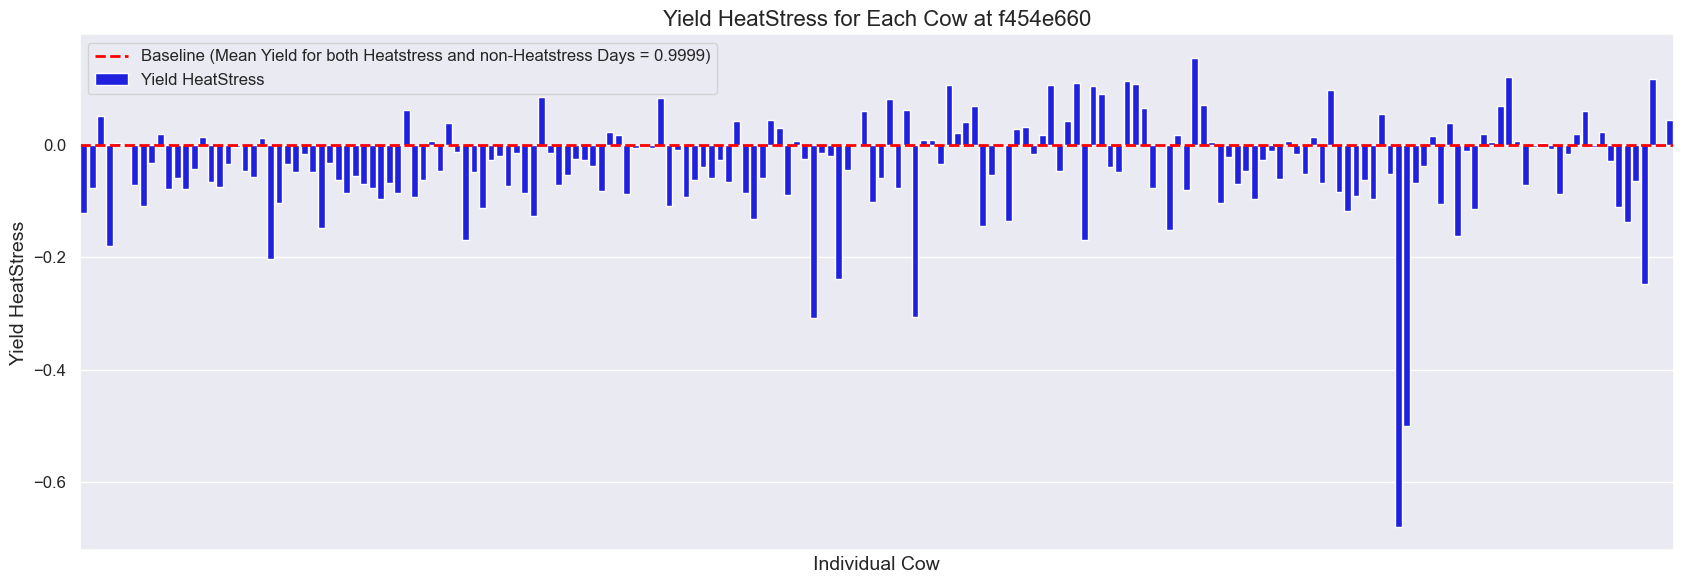

In [16]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

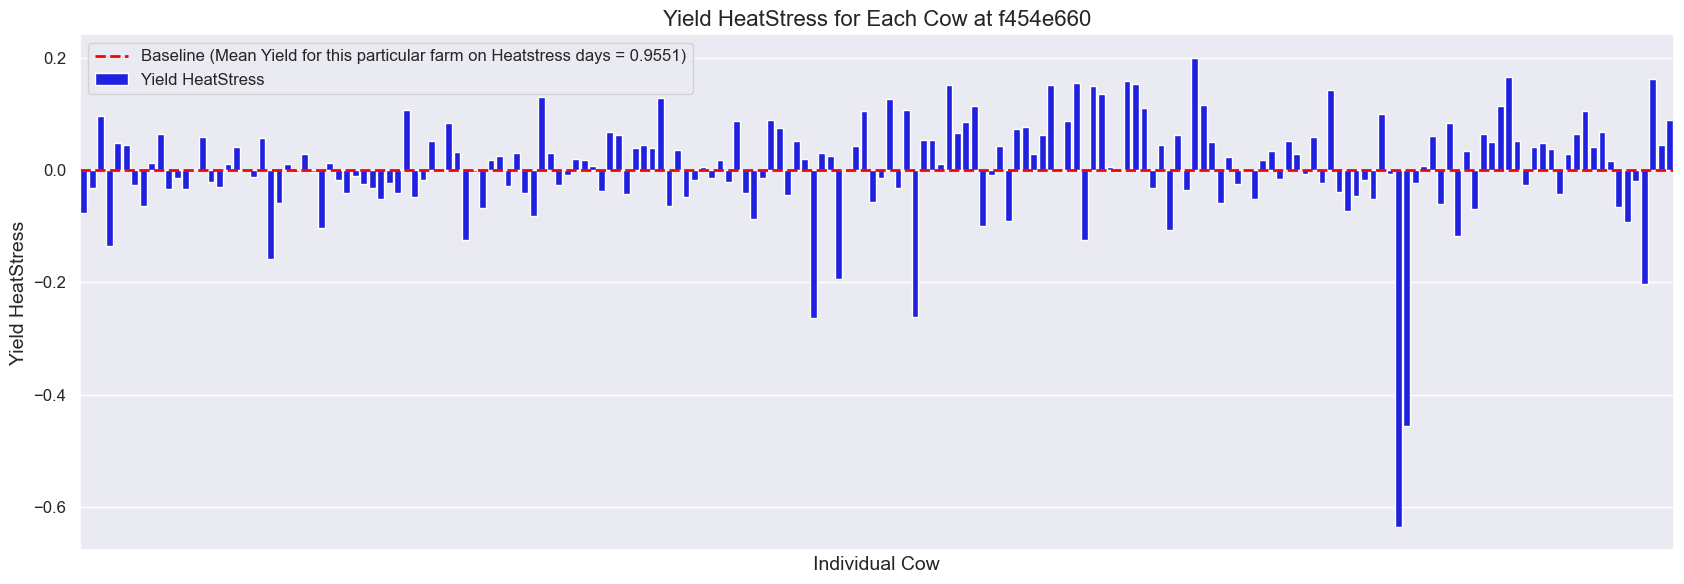

In [17]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

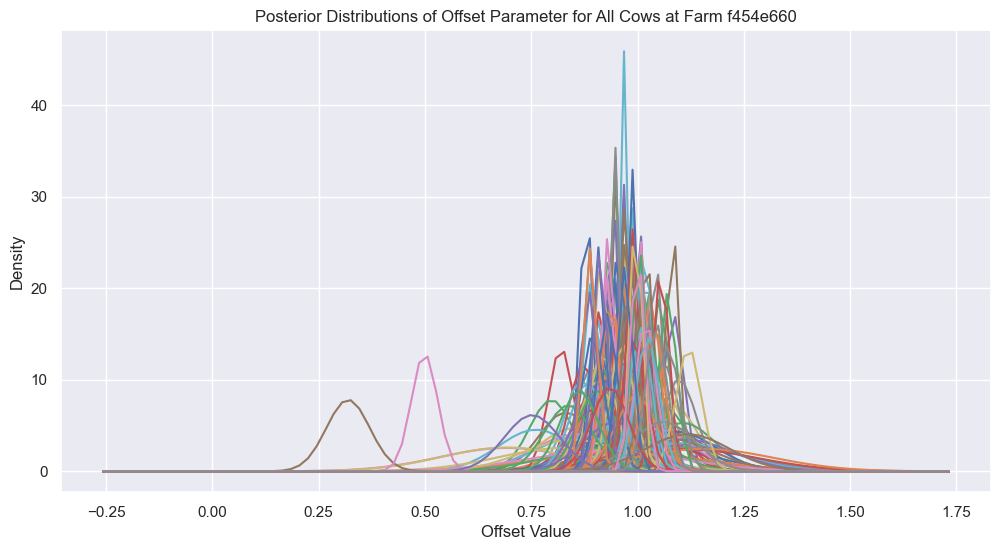

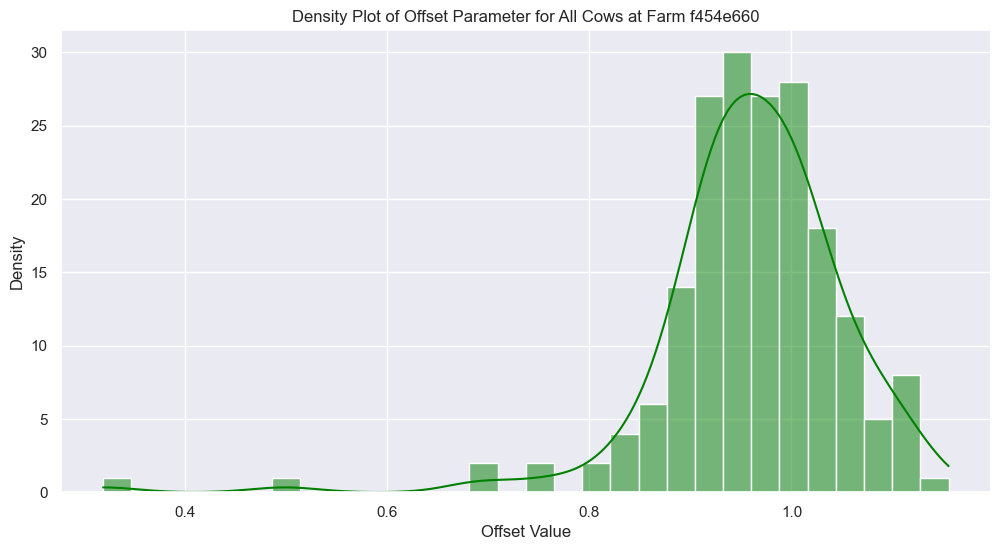

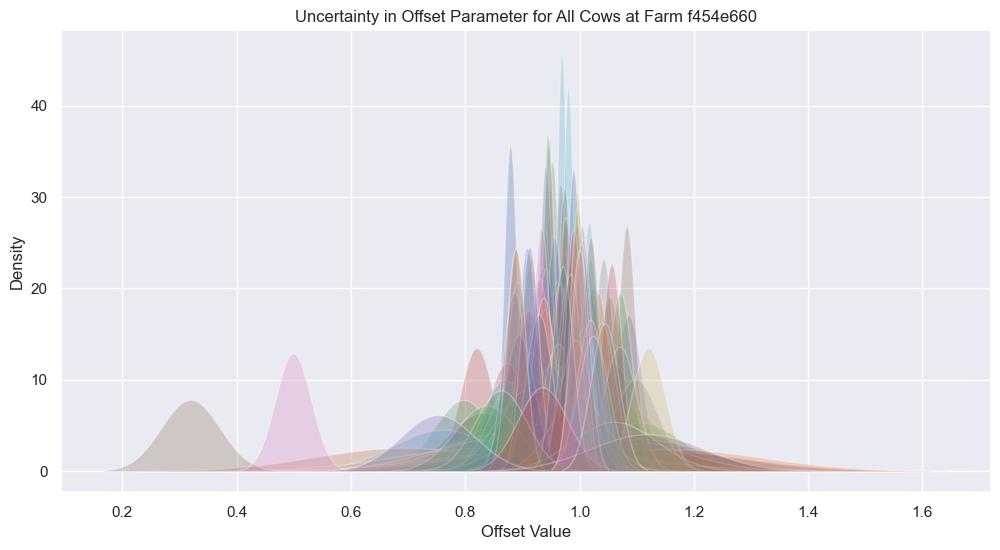

In [18]:
# Initialize lists to store aggregated data
offset_mus = []
offset_sigmas = []

# Extract offset parameters from each model
for model in models:
    offset_mu = model.posterior.mean[0][0]
    offset_sigma = np.sqrt(model.posterior.cov[0, 0])
    offset_mus.append(offset_mu)
    offset_sigmas.append(offset_sigma)

# Posterior Distribution Plot for all cows
plt.figure(figsize=(12, 6))
xx = np.linspace(min(offset_mus) - 3 * max(offset_sigmas), max(offset_mus) + 3 * max(offset_sigmas), 100)
for mu, sigma in zip(offset_mus, offset_sigmas):
    sns.lineplot(x=xx, y=stats.norm.pdf(xx, mu, sigma))
plt.title(f'Posterior Distributions of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot for all offset parameter estimates
plt.figure(figsize=(12, 6))
sns.histplot(offset_mus, bins=30, kde=True, color='green')
plt.title(f'Density Plot of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Uncertainty Plot for all cows
plt.figure(figsize=(12, 6))
for mu, sigma in zip(offset_mus, offset_sigmas):
    xx = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.fill_between(xx, stats.norm.pdf(xx, mu, sigma), alpha=0.3)
plt.title(f'Uncertainty in Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()